In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('./data/processed/np_sig_SR_2.npy')
test_data = np.load('./data/processed/test_dat.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

12

In [3]:
def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [4]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [5]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [6]:
generated_data = generate_gan(gen_model,np_bg_SR)
generated_data2 = generate_gan(gen_model,np_bg_SR)
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)

In [7]:
gl = pd.DataFrame(generated_data_labeled, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb'])

In [8]:
gl

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb
0,1318.605883,-1.438315,106.428897,915.559303,0.672835,3.406282,284.252656,0.407870,0.503047,3653.600586,0.0
1,1413.894948,-0.273506,170.512202,1386.126833,1.014183,3.190410,346.026385,0.628195,0.503969,3321.802979,0.0
2,1741.508688,-0.343517,134.462615,1774.204372,0.096540,3.126636,133.841959,0.274486,0.234642,3460.311035,0.0
3,1620.612508,-0.312288,109.418501,1619.688438,0.670032,3.090500,36.846459,0.393514,0.801951,3525.179688,0.0
4,1256.866657,-1.249923,146.292308,684.431761,1.253384,3.116061,90.028515,0.376290,0.848239,3664.344971,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1715.150835,-0.491213,442.520725,1682.522405,-0.777476,3.150301,54.089590,0.371485,0.735489,3314.205811,0.0
99996,1776.541124,0.680096,404.716182,1803.634299,0.494422,3.134164,157.307388,0.295110,0.623176,3521.510742,0.0
99997,1331.007128,-0.967184,389.185891,1302.482129,0.614890,3.146739,143.763938,0.623273,0.170532,3479.750488,0.0
99998,1688.851315,0.693714,85.161232,1533.589748,-0.229150,3.179059,279.434561,0.434378,0.520212,3433.479248,0.0


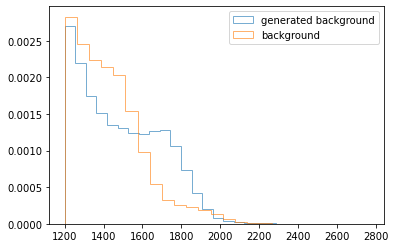

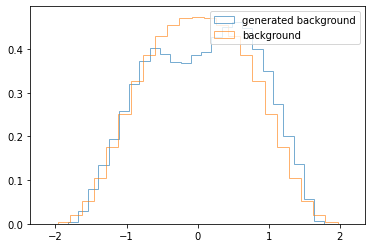

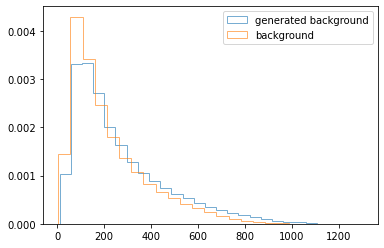

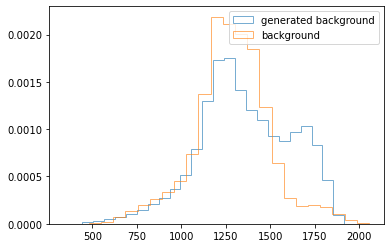

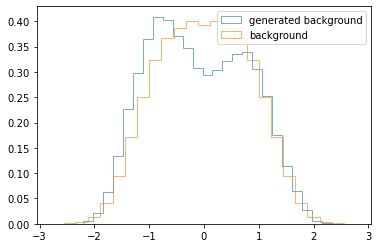

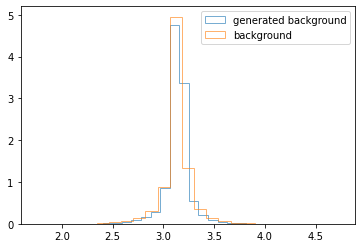

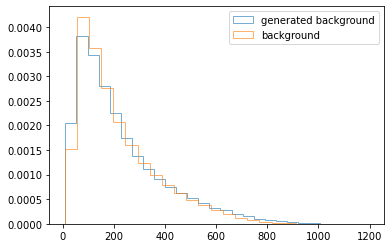

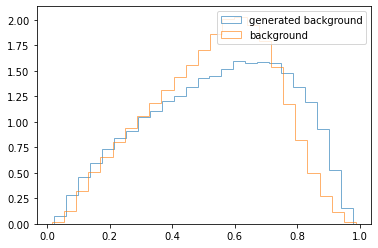

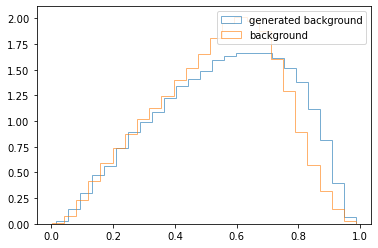

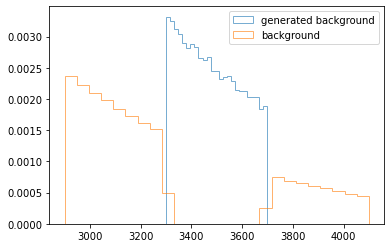

In [9]:
for i in range(0,10):
    plt.hist(generated_data[:,i],25,alpha=0.6,histtype = 'step',label = 'generated background',density = True)
    #plt.hist(np_sig_SB[:,i],25,alpha = 0.6,histtype = 'step',label = 'signal',density = True)
    plt.hist(np_bg_SB[:,i],25,alpha = 0.6,histtype = 'step',label = 'background',density = True)
    plt.legend()
    plt.show()

In [30]:
eff_ratio_4c = []
for i in range(len(tpr_list)):
    tpr_list[i] = tpr_list[i] + 0.0000001
    fpr_list[i] = fpr_list[i] + 0.0000001
    eff_ratio_4c.append(max(tpr_list[i]/np.sqrt(fpr_list[i]))) 

Text(0.5, 0, 's/b')

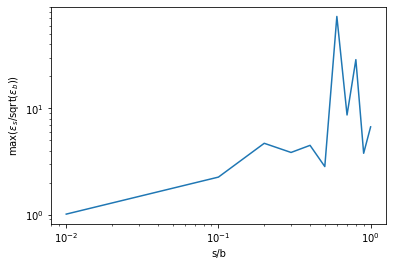

In [31]:
plt.plot(sb_ratio,eff_ratio_4c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('max($\epsilon_s$/sqrt$(\epsilon_b$))')
plt.xlabel('s/b')

In [54]:
th_list[0]

array([1.9806349 , 0.9806349 , 0.97947687, ..., 0.11825566, 0.11689245,
       0.09856796], dtype=float32)

In [79]:
fp_at_tp50 = []
for i in range(len(tpr_list)):
    a = np.where(np.logical_and(th_list[i]>=0.49999, th_list[i]<=0.50001))
    index = a[0][0]
    fp_at_tp50.append(fpr_list[i][index])

Text(0.5, 0, 's/b')

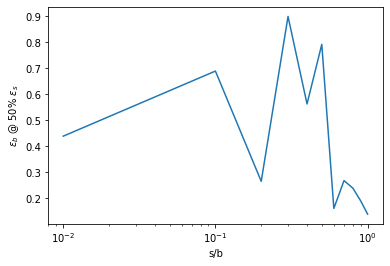

In [83]:
plt.plot(sb_ratio,fp_at_tp50)
plt.xscale('log')
plt.ylabel('$\epsilon_b$ @ 50% $\epsilon_s$')
plt.xlabel('s/b')

In [84]:
fp_at_tp50 = []
tp_at_tp50 = []
for i in range(len(tpr_list)):
    a = np.where(np.logical_and(th_list[i]>=0.49999, th_list[i]<=0.50001))
    index = a[0][0]
    tp_at_tp50.append(tpr_list[i][index])
    fp_at_tp50.append(fpr_list[i][index])

In [88]:
sb_50 = tp_at_tp50/np.sqrt(fp_at_tp50)

Text(0.5, 0, 's/b')

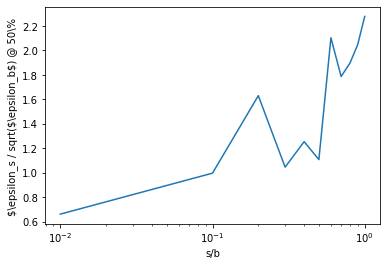

In [99]:
plt.plot(sb_ratio,sb_50)
plt.xscale('log')
plt.ylabel('$\epsilon_s / sqrt($\epsilon_b$) @ 50\% ')
plt.xlabel('s/b')

In [35]:
np.where((tpr_list[0] >= 0.499999999999999999999) & (tpr_list[0] >= 0.5000000000000000000000000001))[0]

array([53167, 53168, 53169, ..., 78385, 78386, 78387])

Text(0.5, 0, 's/b')

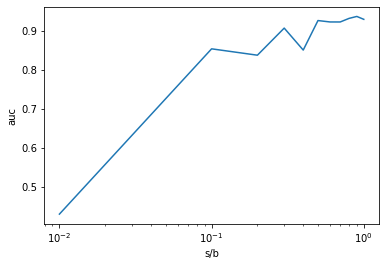

In [202]:
rmse= np.asarray(rmse)
plt.plot(sb,auc_list)
plt.xscale('log')
plt.ylabel('auc')
plt.xlabel('s/b')


In [31]:
np.sqrt(rmse)

array([], dtype=float64)

In [84]:
maxtpr_list = []
for i in range(len(sb)):
    tpr_avg = []
    for j in range(5):
        tpr = np.load('./Results/Classifier/sb' +str(sb[i])+'/tpr_list_'+str(j)+'_'+str(sb[i])+'.npy', allow_pickle=True)[0]
        fpr = np.load('./Results/Classifier/sb' +str(sb[i])+'/fpr_list_'+str(j)+'_'+str(sb[i])+'.npy', allow_pickle=True)[0]
        tpr = tpr + 0.0000001
        fpr = fpr + 0.0000001
        m = max(tpr/np.sqrt(fpr))
        print(m)
        
        tpr_avg.append(m)
    print('____')
    maxtpr_list.append(np.mean(tpr_avg))

12.775917974846271
16.191177847828122
127.88282480497527
25.55151972192652
23.52766201941876
____
43.19702906566608
26.310466360366927
18.910736635572928
70.8353358155377
20.808103231673954
____
14.357056804930458
30.105199552568987
5.987893433960152
5.0015747909487756
5.595761340186703
____
26.689939679587134
7.109974846559427
14.799775677354033
11.70074357038902
5.590959932869785
____
126.93414150692477
5.691076500400567
30.927391744212766
30.48467287178919
9.267137283256266
____
19.037227741979663
14.61003901774393
6.177684034420424
11.258024697965446
30.927391744212766
____
27.95485074365449
54.89745640828908
7.006463697162463
3.0824511983313947
10.182850293508197
____
40.983434703548205
17.898807784319043
39.14931366065055
19.29020995479313
6.198380441696039
____
105.55714452418653
82.40927205175397
42.438082427225666
15.748458975404546
1.5738382172726508
____
52.683862046171214
67.23033928294576
6.757367465026976
19.037227741979663
10.941796931948609
____
1.015043474171898
1.1277

Text(0.5, 0, 's/b')

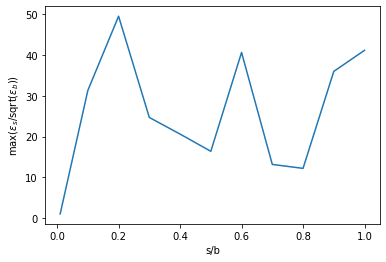

In [76]:
plt.plot(sb,maxtpr_list)

plt.ylabel('max($\epsilon_s$/sqrt$(\epsilon_b$))')
plt.xlabel('s/b')

In [151]:
fpr50_list = []
for i in range(len(sb)):
    fpr_avg = []
    print('sb is ' + str(sb[i]))
    for j in range(5):
        tpr = np.load('./Results/Classifier/sb' +str(sb[i])+'/tpr_list_'+str(j)+'_'+str(sb[i])+'.npy', allow_pickle=True)[0]
        fpr = np.load('./Results/Classifier/sb' +str(sb[i])+'/fpr_list_'+str(j)+'_'+str(sb[i])+'.npy', allow_pickle=True)[0]
        tpr = tpr + 0.0000001
        fpr = fpr + 0.0000001
        tpr_indx = np.where((tpr >= 0.499999) & (tpr <= 0.50001))[0]
        if(len(tpr_indx!=0)):
            index = tpr_indx[0]
        
        #print(tpr_indx)
        print(tpr[index])
        print(fpr[index])
        
        fpr_avg.append(fpr[index])
    print('____')
    fpr50_list.append(np.mean(fpr_avg))

sb is 1
0.5000001
0.012586766666666666
0.5000001
0.021186766666666666
0.5000001
0.014020099999999999
0.5000001
0.005573433333333333
0.5000001
0.0063534333333333335
____
sb is 0.9
0.5000001
0.004573433333333334
0.5000001
0.0112401
0.5000001
0.0108001
0.5000001
0.008646766666666666
0.5142000999999999
0.008046766666666667
____
sb is 0.8
0.5000001
0.007153433333333334
0.5058201
0.006326766666666667
0.5000001
0.008586766666666665
0.4952801
0.011333433333333334
0.5000001
0.009600099999999999
____
sb is 0.7
0.5038800999999999
0.010273433333333333
0.4969001
0.010293433333333333
0.4895401
0.011600099999999999
0.5000001
0.009146766666666667
0.5000001
0.009033433333333334
____
sb is 0.6
0.5172800999999999
0.0066867666666666666
0.5054601
0.0084201
0.5021201
0.008866766666666666
0.4964201
0.0095601
0.5154200999999999
0.0072201
____
sb is 0.5
0.5038201
0.0089401
0.4998801
0.0095401
0.5000001
0.0073201
0.5000001
0.008346766666666667
0.5000001
0.0068601
____
sb is 0.4
0.4654401
0.013553433333333333
0.

In [152]:
fpr50_list

[0.0119441,
 0.008661433333333333,
 0.0086001,
 0.010069433333333332,
 0.008150766666666667,
 0.008201433333333332,
 0.014608099999999999,
 0.012072099999999999,
 0.01975343333333333,
 0.0104841,
 0.7206627666666667]

Text(0.5, 0, 's/b')

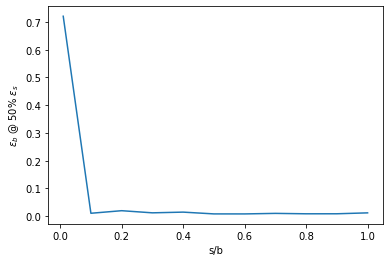

In [153]:
plt.plot(sb,fpr50_list)
plt.ylabel('$\epsilon_b$ @ 50% $\epsilon_s$')
plt.xlabel('s/b')

Text(0.5, 0, 's/b')

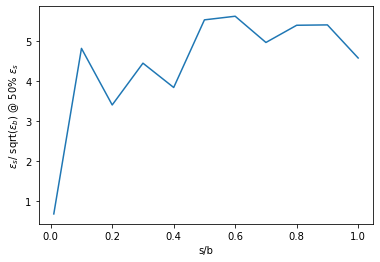

In [158]:
plt.plot(sb,tfpr50_list)
plt.ylabel('$\epsilon_s$/ sqrt($\epsilon_b$) @ 50% $\epsilon_s$')
plt.xlabel('s/b')

In [11]:

sb_ratio = [0.001     , 0.00215443, 0.00464159,0.01      , 0.02154435, 0.04641589, 0.1       , 0.21544347  ,0.46415888 , 1.]

In [28]:
auc_list = []
auc_std = []
for i in range(len(sb_ratio)):
    auc_avg = []
    for j in range(50):
        auc_avg.append(np.load('./Results/Classifier/50iter/auc/'+str(sb_ratio[i])+'/auc_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0])

    auc_list.append(np.mean(auc_avg,axis=0))
    auc_std.append(np.std(auc_avg,axis=0))

In [29]:
auc_std

[0.0661001312270632,
 0.06266159586301671,
 0.0575444601426572,
 0.0697508372901537,
 0.09296264449696358,
 0.14293283534491882,
 0.12280041804038214,
 0.1293954538203773,
 0.05007459111466075,
 0.006013383290535787]

Text(0.5, 0, 's/b')

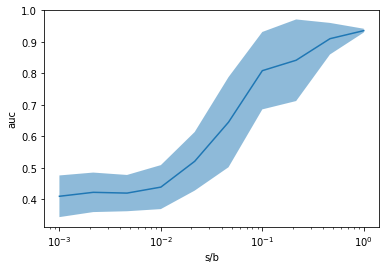

In [47]:
plt.plot(sb_ratio,auc_list)
plt.fill_between(np.logspace(-3,0,10), np.asarray(auc_list) - np.asarray(auc_std), np.asarray(auc_list)+np.asarray(auc_std),alpha = 0.5)        
plt.xscale('log')
plt.ylabel('auc')
plt.xlabel('s/b')
plt.

In [67]:
maxtpr_list = []
maxtpr_sd = []
for i in range(len(sb_ratio)):
    tpr_avg = []
    for j in range(50):
        tpr = np.load('./Results/Classifier/50iter/tpr/' +str(sb_ratio[i])+'/tpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        fpr = np.load('./Results/Classifier/50iter/fpr/' +str(sb_ratio[i])+'/fpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        tpr = tpr + 0.0000001
        fpr = fpr + 0.0000001
        m = max(tpr/np.sqrt(fpr))
        #print(m)
        
        tpr_avg.append(m)
    #print('____')
    maxtpr_list.append(np.mean(tpr_avg,axis=0))
    maxtpr_sd.append(np.std(tpr_avg,axis=0))

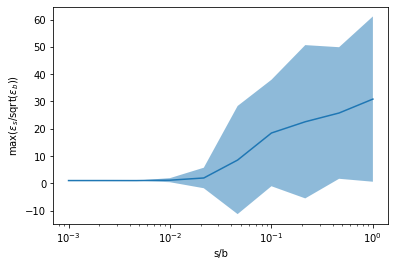

In [68]:
plt.plot(sb_ratio,maxtpr_list)
plt.fill_between(np.logspace(-3,0,10), np.asarray(maxtpr_list) - np.asarray(maxtpr_sd), np.asarray(maxtpr_list)+np.asarray(maxtpr_sd),alpha = 0.5) 
plt.ylabel('max($\epsilon_s$/sqrt$(\epsilon_b$))')
plt.xlabel('s/b')
plt.xscale('log')

In [100]:
fpr50_list = []
fpr50_sd = []
for i in range(len(sb_ratio)):
    fpr_avg = []
    #print('sb is ' + str(sb_ratio[i]))
    for j in range(50):
        tpr = np.load('./Results/Classifier/50iter/tpr/' +str(sb_ratio[i])+'/tpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        fpr = np.load('./Results/Classifier/50iter/fpr/' +str(sb_ratio[i])+'/fpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        tpr = tpr + 0.0000001
        fpr = fpr + 0.0000001
        if(len(tpr)<50000):
            continue
        tpr_indx = np.where((tpr >= 0.499999) & (tpr <= 0.50001))[0]
        if(len(tpr_indx!=0)):
            index = tpr_indx[0]
        #print("index" + str(index))
        #print(len(tpr))

        
        fpr_avg.append(fpr[index])
    #print(np.mean(fpr_avg))
    #print('____')
    fpr50_list.append(np.mean(fpr_avg,axis=0))
    fpr50_sd.append(np.std(fpr_avg,axis=0))

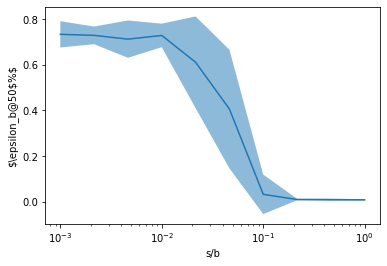

In [101]:
plt.plot(sb_ratio,fpr50_list)
plt.fill_between(np.logspace(-3,0,10), np.asarray(fpr50_list) - np.asarray(fpr50_sd), np.asarray(fpr50_list)+np.asarray(fpr50_sd),alpha = 0.5) 
plt.ylabel('$\epsilon_b@50$%$')
plt.xlabel('s/b')
plt.xscale('log')

In [103]:
tfpr50_list = []
tfpr50_sd = []

for i in range(len(sb_ratio)):
    fpr_avg2 = []
    tpr_avg2 = []
    for j in range(50):
        tpr = np.load('./Results/Classifier/50iter/tpr/' +str(sb_ratio[i])+'/tpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        fpr = np.load('./Results/Classifier/50iter/fpr/' +str(sb_ratio[i])+'/fpr_list_'+str(j)+'_'+str(sb_ratio[i])+'.npy', allow_pickle=True)[0]
        tpr = tpr + 0.0000001
        fpr = fpr + 0.0000001
        tpr_indx = np.where((tpr >= 0.499999) & (tpr <= 0.50001))[0]
        if(len(tpr)<50000):
            continue
        if(len(tpr_indx!=0)):
            index = tpr_indx[0]
        

        tpr_avg2.append(tpr[index])
        fpr_avg2.append(fpr[index])
    #print('____')
    tfpr50_list.append(np.mean(tpr_avg2/np.sqrt(np.mean(fpr_avg2))))
    tfpr50_sd.append(np.std(tpr_avg2/np.sqrt(np.std(fpr_avg2))))

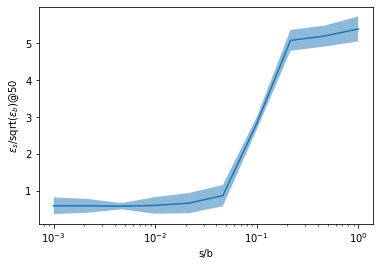

In [106]:
plt.plot(sb_ratio,tfpr50_list)
plt.fill_between(np.logspace(-3,0,10), np.asarray(tfpr50_list) - np.asarray(tfpr50_sd), np.asarray(tfpr50_list)+np.asarray(tfpr50_sd),alpha = 0.5) 
plt.ylabel('$\epsilon_s$/sqrt($\epsilon_b$)@50')
plt.xlabel('s/b')
plt.xscale('log')